# 1. darknet clone
runntime => GPU

In [1]:
#clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15214, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 15214 (delta 15), reused 19 (delta 12), pack-reused 15185
Receiving objects: 100% (15214/15214), 13.65 MiB | 16.18 MiB/s, done.
Resolving deltas: 100% (10325/10325), done.


In [ ]:
!ls -al darknet/

In [ ]:
%cd darknet

In [ ]:
!ls -al

In [5]:
#change makefile to have OPENCV, GPU, CUDNN enabled
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

In [ ]:
#verify CUDA
!/usr/local/cuda/bin/nvcc --version

In [ ]:
#compile sources
!make

In [ ]:
#get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

In [ ]:
#run darknet detection
!./darknet detect cfg/yolov3.cfg yolov3.weights data/giraffe.jpg

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import IPython
import time
import math

result = cv2.imread('predictions.jpg')
cv2_imshow(result)

#2. OpenCV YOLO video

In [11]:
min_confidence = 0.5

In [12]:
weight_file = 'yolov3.weights'
cfg_file = 'cfg/yolov3.cfg'
name_file = 'data/coco.names'

#https://bdd-data.berkeley.edu/ 에서 dataset download
#http://dl.yf.io/bdd100k/video_parts/bdd100k_videos_test_00.zip의 첫번째 video file
file_name = 'cabc30fc-e7726578.mp4'

In [13]:
!ls -al cfg/yolov3.cfg

-rw-r--r-- 1 root root 8342 Jul  7 23:02 cfg/yolov3.cfg


In [14]:
#load yolo
net = cv2.dnn.readNet(weight_file, cfg_file)

In [15]:
classes = []
with open(name_file, 'r') as f:
  classes = [line.strip() for line in f.readlines()]
print(classes)
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0]-1] for i in net.getUnconnectedOutLayers()]

colors = np.random.uniform(0, 255, size=(len(classes), 3))

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [16]:
from google.colab import files
files.upload()

Saving cabc30fc-e7726578.mp4 to cabc30fc-e7726578.mp4


In [20]:
frame_count = 0
#initialize the video writer
writer = None
output_name = 'output_video.avi'

In [19]:
def writeFrame(img):
  #use global variable, writer
  global writer, frame_count
  frame_count += 1
  print("Frame: ", frame_count)
  height, width  = img.shape[:2]
  if writer is None and output_name is not None:
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter(output_name, fourcc, 24, (width, height), True)
  if writer is not None:
    writer.write(img)

In [17]:
def detectAndDisplay(frame):
  global frame_count
  frame_count += 1
  start_time = time.time()

  IPython.display.clear_output(wait=True)
  height, width, channels = frame.shape

  blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0,0,0), True, crop=False)

  net.setInput(blob)
  outs = net.forward(output_layers)
  
  class_ids = []
  confidences = []
  boxes = []
  
  for out in outs:
    for detection in out:
      scores = detection[5:]
      class_id = np.argmax(scores)
      confidence = scores[class_id]
      if confidence > min_confidence:
        #object detected
        center_x = int(detection[0]*width)
        center_y = int(detection[1]*height)
        w = int(detection[2]*width)
        h = int(detection[3]*height)

        #rectangle coordinates
        x = int(center_x - w / 2)
        y = int(center_y - h / 2)

        boxes.append([x, y, w, h])
        confidences.append(float(confidence))
        class_ids.append(class_id)

  #Region of interest
  mask = np.zeros((height, width), dtype='uint8')

  poly_top = int(0.65*height)
  poly_bottom = int(0.85 * height)  
  poly_left = int(0.47 * width)
  poly_right = int(0.53 * width)
  poly_margin = 50
  polygons = np.array([[(0+poly_margin,poly_bottom), (poly_left, poly_top), (poly_right, poly_top), (width-poly_margin, poly_bottom)]])
  cv2.fillPoly(mask, polygons, 255)

  indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)
  font = cv2.FONT_HERSHEY_COMPLEX
  margin = 5
  for i in range(len(boxes)):
    if i in indexes:
      x, y, w, h = boxes[i]
      label = str(classes[class_ids[i]])
      print(i, label)
      color = colors[i]
      cv2.rectangle(frame, (x,y), (x+w, y+h), color, 2)
      cv2.putText(frame, label, (x, y+30), font, 0.5, (0, 255, 0), 1)
      #bitwise operation between box and mask
      box = np.array([[(x-margin, y+h+margin), (x-margin,y-margin), (x+w+margin,y),(x+w+margin, y+h+margin)]])
      cv2.fillPoly(mask, box, 0)
  
  #lane detection
  gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

  #gaussianblur for refucing noise
  blur = cv2.GaussianBlur(gray, (5,5), 0)

  canny = cv2.Canny(blur, 40, 130)

  #bitwise operation between poly and mask
  masked = cv2.bitwise_and(canny, mask)

  #lane detection
  lines = cv2.HoughLinesP(masked, 2, np.pi / 180, 20, np.array([]), 20, 10)

  if lines is not None:
    for line in lines:
      for x1, y1, x2, y2 in line:
        cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 255), 5)

  frame_time = time.time() - start_time
  print("Frame {} time {}".format(frame_count, frame_time))
  cv2_imshow(frame)
  writeFrame(frame)

0 car
1 motorbike
3 bicycle
Frame 2405 time 1.9733989238739014


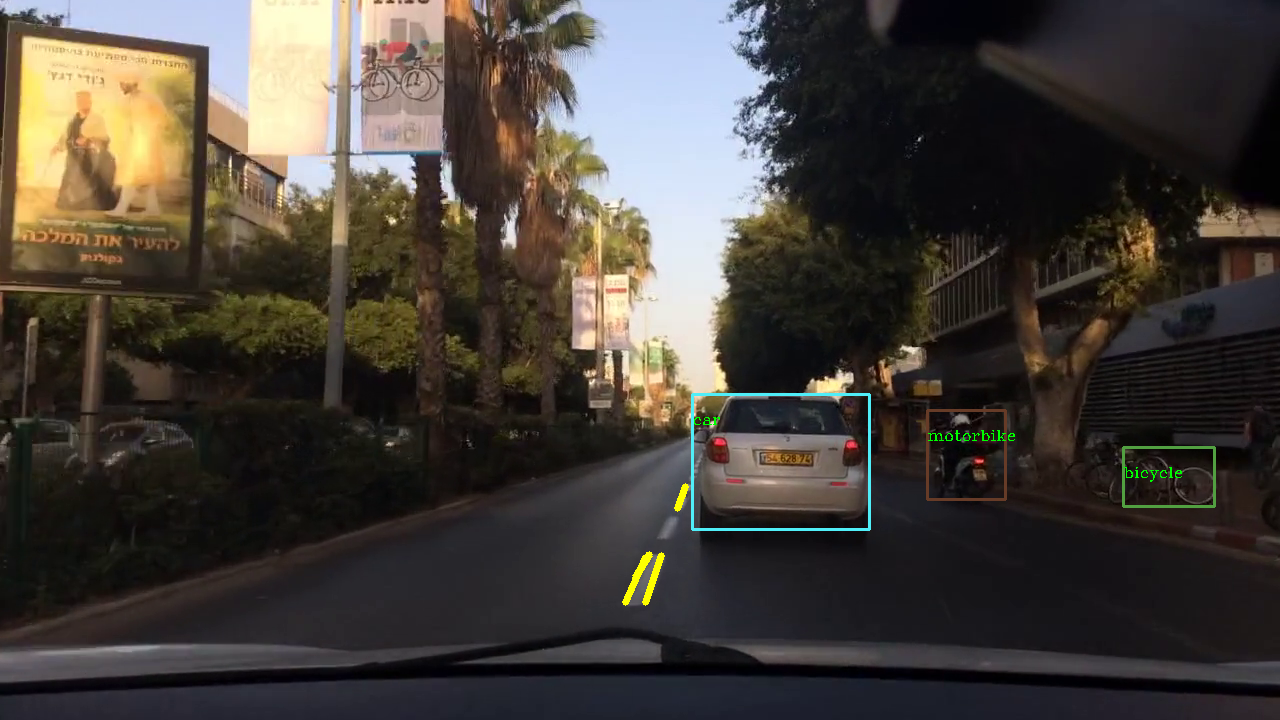

Frame:  2406
captured frame - break


In [21]:
cap = cv2.VideoCapture(file_name)
if not cap.isOpened:
  print('opening video capture')
  exit(0)

while True:
  re, frame = cap.read()
  if frame is None:
    print('captured frame - break')
    break
  detectAndDisplay(frame)